# 📊 Marketing Performance & Predictive Modeling Project

## 🚀 Executive Summary

This project builds an end-to-end marketing analytics and predictive modeling framework to:

- Analyze campaign performance across channels, platforms, and audiences
- Identify performance drivers (profitability, efficiency, engagement)
- Forecast user behavior (click or conversion likelihood)
- Extract actionable feature importance insights to guide optimization

The objective is to move beyond descriptive metrics and into **predictive, performance-driven marketing strategy.**

---

# 🎯 Business Objectives

### 1️⃣ Performance Optimization
- Which campaigns, channels, and audience segments drive the highest Net ROAS?
- Where is budget over-allocated or under-utilized?
- Which placements or creatives are inefficient?

### 2️⃣ Funnel Diagnostics
- Are we driving quality clicks (CTR vs CVR)?
- Where does the conversion funnel break?
- Is ad fatigue impacting performance?

### 3️⃣ Profitability Analysis
- How do refunds impact net revenue?
- Which segments are profitable after spend?
- Which landing pages convert efficiently?

### 4️⃣ Predictive Modeling
- Can we predict click likelihood or conversion probability?
- What features most strongly influence engagement?

---

# 🧠 Data Engineering & Feature Preparation

The dataset includes 300+ marketing features across:

- Campaign performance metrics (CTR, CPC, CPM, CPA, ROAS, Net ROAS)
- Engagement metrics (video completion %, watch time, email open rate)
- Financial indicators (gross profit, refund rate, net revenue)
- Audience attributes (segment, geo, device, channel)
- Time-based signals (day of week, hour, seasonal flags)
- Interaction features (spend × quality, CTR × CVR, lift ratios)


# Import Python Libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

In [7]:
df = pd.read_csv('advertising.csv')

In [8]:
df.head(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,date,channel,device,geo_region,objective,creative_type,campaign_name,ad_group,audience_segment,impressions,clicks,spend,conversions,avg_conversion_value,revenue,gross_margin_pct,gross_profit,ctr,cpc,cpm,cvr,cpa,roas,budget,budget_utilization,quality_score,ad_rank,event_timestamp,day_of_week,hour_of_day,is_weekend,month,quarter,is_holiday_peak,platform,bid_strategy,placement,landing_page,attribution_window,reach,frequency,viewability_rate,brand_safety_risk,video_views,video_25pct,video_50pct,video_75pct,video_100pct,avg_watch_time_sec,emails_sent,email_opens,email_clicks,unsubscribe_rate,keyword,match_type,competition_index,view_through_conversions,refund_rate,refund_amount,net_revenue,net_roas
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,2024-03-06,Video,Desktop,US-NE,Leads,Static,ProductLaunch_Video_202403,AG_23,Loyal Customers,4327,40,47.63,1,22.84,22.84,0.355,8.11,0.0092,1.19,11.01,0.0250,47.63,0.480,33013.10,0.0014,7.0,NaN,2024-03-06 00:30:08,Wednesday,0,0,3,1,0,TikTok Ads,Maximize Conversions,YouTube,/product,1d_view,1534,2.82,0.611,Low,482.0,406.0,332.0,254.0,215.0,7.1,NaN,NaN,NaN,NaN,NaN,NaN,48,0,0.0185,0.42,22.42,0.471
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,2025-07-19,Email,Tablet,US-W,Leads,Short Video,Prospecting_Email_202507,AG_21,Returning Users,526,7,1.12,0,21.63,0.00,0.442,0.00,0.0133,0.16,2.13,0.0000,NaN,0.000,6069.63,0.0002,8.2,NaN,2025-07-19 16:52:27,Saturday,16,1,7,3,0,ESP,NaN,Newsletter,/pricing,7d_click,194,2.71,0.589,Low,NaN,NaN,NaN,NaN,NaN,NaN,1276.0,334.0,53.0,0.0033,NaN,NaN,29,0,0.0094,0.00,0.00,0.000
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,2025-04-23,Email,Mobile,EU,Awareness,Long Video,Remarketing_Email_202504,AG_04,High Intent,986,36,10.45,3,23.07,69.21,0.359,24.85,0.0365,0.29,10.60,0.0833,3.48,6.623,7938.26,0.0013,6.6,NaN,2025-04-23 14:50:45,Wednesday,14,0,4,2,0,ESP,NaN,Newsletter,/category,1d_click,619,1.59,0.593,Low,NaN,NaN,NaN,NaN,NaN,NaN,2814.0,558.0,107.0,0.0036,NaN,NaN,39,0,0.0033,0.23,68.98,6.601


# Feaeture Engineer new columns

In [9]:
# Helpers
# ----------------------------
def safe_div(n, d):
    """Safe division for pandas Series (avoid /0 and inf)."""
    d2 = d.replace(0, np.nan) if isinstance(d, pd.Series) else (np.nan if d == 0 else d)
    out = n / d2
    return out.replace([np.inf, -np.inf], np.nan)

# ----------------------------
# Feature engineering
# ----------------------------
df_fe = df.copy()

# 1) Datetime parsing + canonical dt
for c in ["Timestamp", "event_timestamp", "date"]:
    if c in df_fe.columns:
        df_fe[c] = pd.to_datetime(df_fe[c], errors="coerce")

if "event_timestamp" in df_fe.columns and df_fe["event_timestamp"].notna().any():
    df_fe["dt"] = df_fe["event_timestamp"]
elif "Timestamp" in df_fe.columns and df_fe["Timestamp"].notna().any():
    df_fe["dt"] = df_fe["Timestamp"]
elif "date" in df_fe.columns and df_fe["date"].notna().any():
    df_fe["dt"] = df_fe["date"]
else:
    df_fe["dt"] = pd.NaT

if df_fe["dt"].notna().any():
    df_fe["dt_year"] = df_fe["dt"].dt.year
    df_fe["dt_month"] = df_fe["dt"].dt.month
    df_fe["dt_day"] = df_fe["dt"].dt.day
    df_fe["dt_dow"] = df_fe["dt"].dt.dayofweek
    df_fe["dt_hour"] = df_fe["dt"].dt.hour
    df_fe["dt_weekofyear"] = df_fe["dt"].dt.isocalendar().week.astype("Int64")
    df_fe["is_month_start"] = df_fe["dt"].dt.is_month_start.astype("Int64")
    df_fe["is_month_end"] = df_fe["dt"].dt.is_month_end.astype("Int64")
    df_fe["dt_day_floor"] = df_fe["dt"].dt.floor("D")

# 2) Missingness flags (often predictive)
for c in df_fe.columns:
    if df_fe[c].isna().any():
        df_fe[f"{c}__is_missing"] = df_fe[c].isna().astype(int)

# 3) Core efficiency features
if {"revenue", "impressions"}.issubset(df_fe.columns):
    df_fe["revenue_per_1k_impr"] = safe_div(df_fe["revenue"], df_fe["impressions"]) * 1000

if {"gross_profit", "impressions"}.issubset(df_fe.columns):
    df_fe["profit_per_1k_impr"] = safe_div(df_fe["gross_profit"], df_fe["impressions"]) * 1000

if {"gross_profit", "clicks"}.issubset(df_fe.columns):
    df_fe["profit_per_click"] = safe_div(df_fe["gross_profit"], df_fe["clicks"])

if {"net_revenue", "spend"}.issubset(df_fe.columns):
    df_fe["net_profit"] = df_fe["net_revenue"] - df_fe["spend"]
    df_fe["net_margin_pct"] = safe_div(df_fe["net_profit"], df_fe["net_revenue"]) * 100

if {"clicks", "impressions"}.issubset(df_fe.columns):
    df_fe["clicks_per_1k_impr"] = safe_div(df_fe["clicks"], df_fe["impressions"]) * 1000

if {"conversions", "clicks"}.issubset(df_fe.columns):
    df_fe["conv_per_click"] = safe_div(df_fe["conversions"], df_fe["clicks"])

if {"spend", "reach"}.issubset(df_fe.columns):
    df_fe["spend_per_reach"] = safe_div(df_fe["spend"], df_fe["reach"])

if {"impressions", "reach"}.issubset(df_fe.columns):
    df_fe["impr_per_reach"] = safe_div(df_fe["impressions"], df_fe["reach"])

if {"view_through_conversions", "conversions"}.issubset(df_fe.columns):
    df_fe["view_through_share"] = safe_div(df_fe["view_through_conversions"], df_fe["conversions"])

if {"refund_amount", "revenue"}.issubset(df_fe.columns):
    df_fe["refund_share_of_revenue"] = safe_div(df_fe["refund_amount"], df_fe["revenue"])

if {"refund_rate", "net_revenue"}.issubset(df_fe.columns):
    df_fe["refund_impact_est"] = df_fe["refund_rate"] * df_fe["net_revenue"]

# 4) Video funnel features
video_cols = {"video_views", "video_25pct", "video_50pct", "video_75pct", "video_100pct"}
if video_cols.issubset(df_fe.columns):
    df_fe["v25_rate"] = safe_div(df_fe["video_25pct"], df_fe["video_views"])
    df_fe["v50_rate"] = safe_div(df_fe["video_50pct"], df_fe["video_views"])
    df_fe["v75_rate"] = safe_div(df_fe["video_75pct"], df_fe["video_views"])
    df_fe["v100_rate"] = safe_div(df_fe["video_100pct"], df_fe["video_views"])
    df_fe["video_drop_25_to_50"] = df_fe["v25_rate"] - df_fe["v50_rate"]
    df_fe["video_drop_50_to_75"] = df_fe["v50_rate"] - df_fe["v75_rate"]
    df_fe["video_drop_75_to_100"] = df_fe["v75_rate"] - df_fe["v100_rate"]

if {"avg_watch_time_sec", "video_views"}.issubset(df_fe.columns):
    df_fe["watch_time_per_view"] = safe_div(df_fe["avg_watch_time_sec"], df_fe["video_views"])

# 5) Email funnel features
if {"emails_sent", "email_opens"}.issubset(df_fe.columns):
    df_fe["email_open_rate"] = safe_div(df_fe["email_opens"], df_fe["emails_sent"])
if {"email_opens", "email_clicks"}.issubset(df_fe.columns):
    df_fe["email_click_to_open"] = safe_div(df_fe["email_clicks"], df_fe["email_opens"])
if {"emails_sent", "email_clicks"}.issubset(df_fe.columns):
    df_fe["email_ctr"] = safe_div(df_fe["email_clicks"], df_fe["emails_sent"])

# 6) Interaction features
if {"spend", "quality_score"}.issubset(df_fe.columns):
    df_fe["spend_x_quality"] = df_fe["spend"] * df_fe["quality_score"]

if {"spend", "competition_index"}.issubset(df_fe.columns):
    df_fe["spend_x_competition"] = df_fe["spend"] * df_fe["competition_index"]

if {"ctr", "cvr"}.issubset(df_fe.columns):
    df_fe["ctr_x_cvr"] = df_fe["ctr"] * df_fe["cvr"]

if {"Daily Time Spent on Site", "Daily Internet Usage"}.issubset(df_fe.columns):
    df_fe["time_spent_x_internet_usage"] = df_fe["Daily Time Spent on Site"] * df_fe["Daily Internet Usage"]

if {"Age", "Area Income"}.issubset(df_fe.columns):
    df_fe["age_x_income"] = df_fe["Age"] * df_fe["Area Income"]

# 7) Nonlinear transforms for skewed metrics
for c in ["spend", "impressions", "clicks", "conversions", "revenue", "net_revenue", "gross_profit",
          "Area Income", "Daily Internet Usage"]:
    if c in df_fe.columns and pd.api.types.is_numeric_dtype(df_fe[c]):
        df_fe[f"log1p_{c}"] = np.log1p(df_fe[c].clip(lower=0))
        df_fe[f"sqrt_{c}"] = np.sqrt(df_fe[c].clip(lower=0))

# 8) Buckets (interpretable segments)
if "Age" in df_fe.columns:
    df_fe["age_bucket"] = pd.cut(
        df_fe["Age"],
        bins=[0, 24, 34, 44, 54, 64, 150],
        labels=["<25", "25-34", "35-44", "45-54", "55-64", "65+"]
    )

if "spend" in df_fe.columns:
    df_fe["spend_bucket"] = pd.qcut(df_fe["spend"].rank(method="first"), 5, labels=["VL", "L", "M", "H", "VH"])

if "quality_score" in df_fe.columns:
    df_fe["quality_bucket"] = pd.qcut(df_fe["quality_score"].rank(method="first"), 4, labels=["Low", "Mid", "High", "Top"])

# 9) Group baselines + lift features (campaign/ad_group/audience/channel)
metric_cols = [c for c in ["ctr", "cvr", "cpc", "cpm", "cpa", "roas", "net_roas", "net_revenue",
                           "gross_profit", "conversions"] if c in df_fe.columns]

def add_group_baseline(df_in, group_col, metrics):
    g = df_in.groupby(group_col, dropna=False)[metrics].mean().add_prefix(f"{group_col}__avg_")
    out = df_in.join(g, on=group_col)
    for m in metrics:
        out[f"{group_col}__{m}_lift"] = out[m] - out[f"{group_col}__avg_{m}"]
        out[f"{group_col}__{m}_ratio"] = safe_div(out[m], out[f"{group_col}__avg_{m}"])
    return out

for gcol in ["campaign_name", "ad_group", "audience_segment", "channel"]:
    if gcol in df_fe.columns and metric_cols:
        df_fe = add_group_baseline(df_fe, gcol, metric_cols)

# 10) 7-day rolling features per campaign (needs dt_day_floor)
if "campaign_name" in df_fe.columns and "dt_day_floor" in df_fe.columns and df_fe["dt_day_floor"].notna().any():
    daily = (df_fe
             .sort_values(["campaign_name", "dt_day_floor"])
             .groupby(["campaign_name", "dt_day_floor"], as_index=False)
             .agg(
                 spend_day=("spend", "sum"),
                 clicks_day=("clicks", "sum"),
                 conv_day=("conversions", "sum"),
                 rev_day=("net_revenue", "sum") if "net_revenue" in df_fe.columns else ("revenue", "sum"),
             ))

    daily = daily.sort_values(["campaign_name", "dt_day_floor"])
    daily["spend_7d"] = daily.groupby("campaign_name")["spend_day"].transform(lambda s: s.rolling(7, min_periods=1).sum())
    daily["clicks_7d"] = daily.groupby("campaign_name")["clicks_day"].transform(lambda s: s.rolling(7, min_periods=1).sum())
    daily["conv_7d"] = daily.groupby("campaign_name")["conv_day"].transform(lambda s: s.rolling(7, min_periods=1).sum())
    daily["rev_7d"] = daily.groupby("campaign_name")["rev_day"].transform(lambda s: s.rolling(7, min_periods=1).sum())
    daily["roas_7d"] = safe_div(daily["rev_7d"], daily["spend_7d"])

    df_fe = df_fe.merge(
        daily[["campaign_name", "dt_day_floor", "spend_7d", "clicks_7d", "conv_7d", "rev_7d", "roas_7d"]],
        on=["campaign_name", "dt_day_floor"],
        how="left",
    )

# 11) One-hot encode low-cardinality categoricals (model friendly)
cat_cols = df_fe.select_dtypes(include=["object", "category"]).columns.tolist()
# Exclude high-cardinality text-like fields to avoid huge matrices
exclude = {"Ad Topic Line", "City", "Country", "landing_page", "keyword"}
cat_cols = [c for c in cat_cols if c not in exclude]

low_card = [c for c in cat_cols if df_fe[c].nunique(dropna=True) <= 20]
df_model = pd.get_dummies(df_fe, columns=low_card, dummy_na=True, drop_first=False)

In [10]:
df_model.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,date,campaign_name,ad_group,impressions,clicks,spend,conversions,avg_conversion_value,revenue,gross_margin_pct,gross_profit,ctr,cpc,cpm,cvr,cpa,roas,budget,budget_utilization,quality_score,ad_rank,event_timestamp,hour_of_day,is_weekend,month,quarter,is_holiday_peak,landing_page,reach,frequency,viewability_rate,video_views,video_25pct,video_50pct,video_75pct,video_100pct,avg_watch_time_sec,emails_sent,email_opens,email_clicks,unsubscribe_rate,keyword,competition_index,view_through_conversions,refund_rate,refund_amount,net_revenue,net_roas,dt,dt_year,dt_month,dt_day,dt_dow,dt_hour,dt_weekofyear,is_month_start,is_month_end,dt_day_floor,cpa__is_missing,ad_rank__is_missing,bid_strategy__is_missing,video_views__is_missing,video_25pct__is_missing,video_50pct__is_missing,video_75pct__is_missing,video_100pct__is_missing,avg_watch_time_sec__is_missing,emails_sent__is_missing,email_opens__is_missing,email_clicks__is_missing,unsubscribe_rate__is_missing,keyword__is_missing,match_type__is_missing,revenue_per_1k_impr,profit_per_1k_impr,profit_per_click,net_profit,net_margin_pct,clicks_per_1k_impr,conv_per_click,spend_per_reach,impr_per_reach,view_through_share,refund_share_of_revenue,refund_impact_est,v25_rate,v50_rate,v75_rate,v100_rate,video_drop_25_to_50,video_drop_50_to_75,video_drop_75_to_100,watch_time_per_view,email_open_rate,email_click_to_open,email_ctr,spend_x_quality,spend_x_competition,ctr_x_cvr,time_spent_x_internet_usage,age_x_income,log1p_spend,sqrt_spend,log1p_impressions,sqrt_impressions,log1p_clicks,sqrt_clicks,log1p_conversions,sqrt_conversions,log1p_revenue,sqrt_revenue,log1p_net_revenue,sqrt_net_revenue,log1p_gross_profit,sqrt_gross_profit,log1p_Area Income,sqrt_Area Income,log1p_Daily Internet Usage,sqrt_Daily Internet Usage,campaign_name__avg_ctr,campaign_name__avg_cvr,campaign_name__avg_cpc,campaign_name__avg_cpm,campaign_name__avg_cpa,campaign_name__avg_roas,campaign_name__avg_net_roas,campaign_name__avg_net_revenue,campaign_name__avg_gross_profit,campaign_name__avg_conversions,campaign_name__ctr_lift,campaign_name__ctr_ratio,campaign_name__cvr_lift,campaign_name__cvr_ratio,campaign_name__cpc_lift,campaign_name__cpc_ratio,campaign_name__cpm_lift,campaign_name__cpm_ratio,campaign_name__cpa_lift,campaign_name__cpa_ratio,campaign_name__roas_lift,campaign_name__roas_ratio,campaign_name__net_roas_lift,campaign_name__net_roas_ratio,campaign_name__net_revenue_lift,campaign_name__net_revenue_ratio,campaign_name__gross_profit_lift,campaign_name__gross_profit_ratio,campaign_name__conversions_lift,campaign_name__conversions_ratio,ad_group__avg_ctr,ad_group__avg_cvr,ad_group__avg_cpc,ad_group__avg_cpm,ad_group__avg_cpa,ad_group__avg_roas,ad_group__avg_net_roas,ad_group__avg_net_revenue,ad_group__avg_gross_profit,ad_group__avg_conversions,ad_group__ctr_lift,ad_group__ctr_ratio,ad_group__cvr_lift,ad_group__cvr_ratio,ad_group__cpc_lift,ad_group__cpc_ratio,ad_group__cpm_lift,ad_group__cpm_ratio,ad_group__cpa_lift,ad_group__cpa_ratio,ad_group__roas_lift,ad_group__roas_ratio,ad_group__net_roas_lift,ad_group__net_roas_ratio,ad_group__net_revenue_lift,ad_group__net_revenue_ratio,ad_group__gross_profit_lift,ad_group__gross_profit_ratio,ad_group__conversions_lift,ad_group__conversions_ratio,audience_segment__avg_ctr,audience_segment__avg_cvr,audience_segment__avg_cpc,audience_segment__avg_cpm,audience_segment__avg_cpa,audience_segment__avg_roas,audience_segment__avg_net_roas,audience_segment__avg_net_revenue,audience_segment__avg_gross_profit,audience_segment__avg_conversions,audience_segment__ctr_lift,audience_segment__ctr_ratio,audience_segment__cvr_lift,audience_segment__cvr_ratio,audience_segment__cpc_lift,audience_segment__cpc_ratio,audience_segment__cpm_lift,audience_segment__cpm_ratio,audience_segment__cpa_lift,audience_segment__cpa_ratio,audience_segment__roas_lift,audience_segment__roas_ratio,audience_segment__n

In [15]:
def has_cols(df_model, cols):
    return all(c in df_model.columns for c in cols)

def safe_div(a, b):
    b = b.replace(0, np.nan) if isinstance(b, pd.Series) else (np.nan if b == 0 else b)
    return a / b

def ensure_datetime(df_model, col):
    if col in df_model.columns:
        df_model[col] = pd.to_datetime(df_model[col], errors="coerce")
    return df_model

# ----------------------------
# Coerce core numerics (if present)
# ----------------------------
numeric_like = [
    "impressions","clicks","spend","conversions","revenue","net_revenue","gross_profit",
    "ctr","cpc","cpm","cvr","cpa","roas","net_roas","budget","budget_utilization",
    "quality_score","ad_rank","reach","frequency","viewability_rate","video_views",
    "video_25pct","video_50pct","video_75pct","video_100pct","avg_watch_time_sec",
    "emails_sent","email_opens","email_clicks","unsubscribe_rate","refund_rate","refund_amount",
    "avg_conversion_value","competition_index","view_through_conversions"
]
for c in numeric_like:
    if c in df_model.columns:
        df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

# ----------------------------
# Ensure datetime fields
# ----------------------------
for dt_col in ["Timestamp","event_timestamp","dt","date","dt_day_floor"]:
    df_model = ensure_datetime(df_model, dt_col)

# Pick a primary datetime
if "dt" in df_model.columns and df_model["dt"].notna().any():
    df_model["dt_primary"] = df_model["dt"]
elif "event_timestamp" in df_model.columns and df_model["event_timestamp"].notna().any():
    df_model["dt_primary"] = df_model["event_timestamp"]
elif "Timestamp" in df_model.columns and df_model["Timestamp"].notna().any():
    df_model["dt_primary"] = df_model["Timestamp"]
elif "date" in df_model.columns and df_model["date"].notna().any():
    df_model["dt_primary"] = df_model["date"]
else:
    df_model["dt_primary"] = pd.NaT

# Derive time grains if missing
if df_model["dt_primary"].notna().any():
    df_model["date_day"] = df_model["dt_primary"].dt.date
    df_model["date_week"] = df_model["dt_primary"].dt.to_period("W").dt.start_time
    df_model["date_month"] = df_model["dt_primary"].dt.to_period("M").dt.start_time

# ----------------------------
# Recompute key rates if needed
# ----------------------------
if has_cols(df_model, ["clicks","impressions"]) and "ctr" not in df_model.columns:
    df_model["ctr"] = safe_div(df_model["clicks"], df_model["impressions"])

if has_cols(df_model, ["spend","clicks"]) and "cpc" not in df_model.columns:
    df_model["cpc"] = safe_div(df_model["spend"], df_model["clicks"])

if has_cols(df_model, ["spend","impressions"]) and "cpm" not in df_model.columns:
    df_model["cpm"] = safe_div(df_model["spend"] * 1000, df_model["impressions"])

if has_cols(df_model, ["conversions","clicks"]) and "cvr" not in df_model.columns:
    df_model["cvr"] = safe_div(df_model["conversions"], df_model["clicks"])

if has_cols(df_model, ["spend","conversions"]) and "cpa" not in df_model.columns:
    df_model["cpa"] = safe_div(df_model["spend"], df_model["conversions"])

if has_cols(df_model, ["revenue","spend"]) and "roas" not in df_model.columns:
    df_model["roas"] = safe_div(df_model["revenue"], df_model["spend"])

if "net_revenue" not in df_model.columns and "revenue" in df_model.columns:
    # if refunds exist, approximate net_revenue
    if "refund_amount" in df_model.columns:
        df_model["net_revenue"] = df_model["revenue"] - df_model["refund_amount"].fillna(0)
    else:
        df_model["net_revenue"] = df_model["revenue"]

if has_cols(df_model, ["net_revenue","spend"]) and "net_roas" not in df_model.columns:
    df_model["net_roas"] = safe_div(df_model["net_revenue"], df_model["spend"])

# Quick sanity
print("Rows:", len(df_model), "| Columns:", df_model.shape[1])
print(df_model.head(3))

Rows: 1000 | Columns: 368
   Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
0                     68.95   35     61833.90                256.09   
1                     80.23   31     68441.85                193.77   
2                     69.47   26     59785.94                236.50   

                        Ad Topic Line         City  Male     Country  \
0  Cloned 5thgeneration orchestration  Wrightburgh     0     Tunisia   
1  Monitored national standardization    West Jodi     1       Nauru   
2    Organic bottom-line service-desk     Davidton     0  San Marino   

            Timestamp  Clicked on Ad       date               campaign_name  \
0 2016-03-27 00:53:11              0 2024-03-06  ProductLaunch_Video_202403   
1 2016-04-04 01:39:02              0 2025-07-19    Prospecting_Email_202507   
2 2016-03-13 20:35:42              0 2025-04-23    Remarketing_Email_202504   

  ad_group  impressions  clicks  spend  conversions  avg_conversion_value  \
0    A

# 1) Executive KPI Snapshot (Overall)

Business questions

- What’s total spend, revenue, profit, ROAS, CPA, CVR?

- Are refunds materially impacting performance?

In [16]:
kpi = {}

if "spend" in df.columns: kpi["Spend"] = df["spend"].sum()
if "revenue" in df.columns: kpi["Revenue"] = df["revenue"].sum()
if "net_revenue" in df.columns: kpi["Net Revenue"] = df["net_revenue"].sum()
if "gross_profit" in df.columns: kpi["Gross Profit"] = df["gross_profit"].sum()
if has_cols(df, ["clicks","impressions"]): kpi["CTR"] = (df["clicks"].sum() / max(df["impressions"].sum(),1))
if has_cols(df, ["spend","clicks"]): kpi["CPC"] = (df["spend"].sum() / max(df["clicks"].sum(),1))
if has_cols(df, ["spend","impressions"]): kpi["CPM"] = (df["spend"].sum() * 1000 / max(df["impressions"].sum(),1))
if has_cols(df, ["conversions","clicks"]): kpi["CVR"] = (df["conversions"].sum() / max(df["clicks"].sum(),1))
if has_cols(df, ["spend","conversions"]): kpi["CPA"] = (df["spend"].sum() / max(df["conversions"].sum(),1))
if has_cols(df, ["revenue","spend"]): kpi["ROAS"] = (df["revenue"].sum() / max(df["spend"].sum(),1))
if has_cols(df, ["net_revenue","spend"]): kpi["Net ROAS"] = (df["net_revenue"].sum() / max(df["spend"].sum(),1))
if "refund_amount" in df.columns: kpi["Refund $"] = df["refund_amount"].sum()

kpi_df = pd.DataFrame([kpi]).T.reset_index()
kpi_df.columns = ["Metric","Value"]
display(kpi_df)

,Metric,Value
0,Spend,117564.860000
1,Revenue,122939.190000
2,Net Revenue,119650.010000
3,Gross Profit,47140.500000
4,CTR,0.018390
5,CPC,1.715950
6,CPM,31.556436
7,CVR,0.050472
8,CPA,33.997935
9,ROAS,1.045714


# 2) Trend: Are we improving week over week?



- Is ROAS trending up or down?

- Are we buying more reach efficiently (CPM)?

- Is CPA stable?

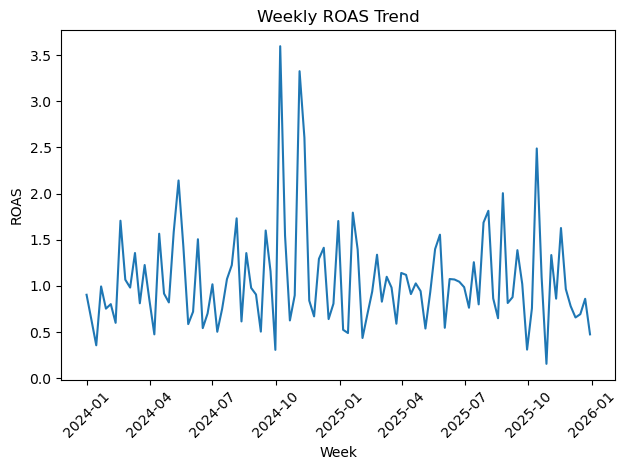

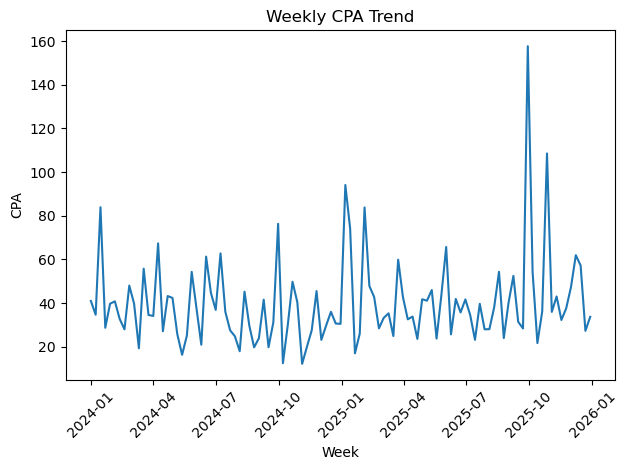

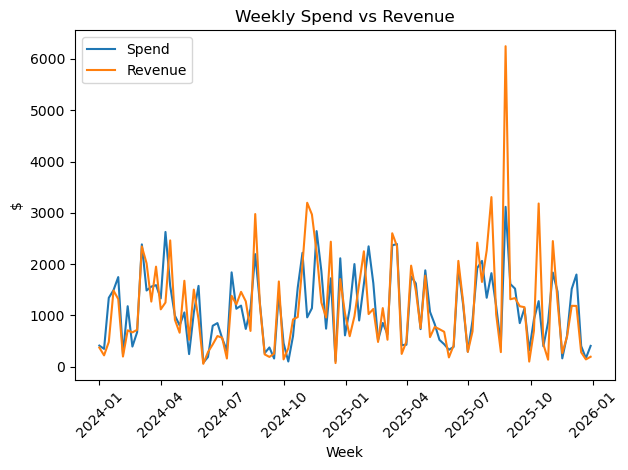

In [19]:
if "date_week" in df.columns and df["date_week"].notna().any():

    agg = df.groupby("date_week").agg(
        impressions=("impressions","sum") if "impressions" in df.columns else ("dt_primary","size"),
        clicks=("clicks","sum") if "clicks" in df.columns else ("dt_primary","size"),
        spend=("spend","sum") if "spend" in df.columns else ("dt_primary","size"),
        conversions=("conversions","sum") if "conversions" in df.columns else ("dt_primary","size"),
        revenue=("revenue","sum") if "revenue" in df.columns else ("dt_primary","size"),
        net_revenue=("net_revenue","sum") if "net_revenue" in df.columns else ("dt_primary","size"),
    ).reset_index()

    if has_cols(agg, ["clicks","impressions"]):
        agg["ctr"] = agg["clicks"] / agg["impressions"].replace(0,np.nan)
    if has_cols(agg, ["spend","clicks"]):
        agg["cpc"] = agg["spend"] / agg["clicks"].replace(0,np.nan)
    if has_cols(agg, ["spend","impressions"]):
        agg["cpm"] = agg["spend"] * 1000 / agg["impressions"].replace(0,np.nan)
    if has_cols(agg, ["conversions","clicks"]):
        agg["cvr"] = agg["conversions"] / agg["clicks"].replace(0,np.nan)
    if has_cols(agg, ["spend","conversions"]):
        agg["cpa"] = agg["spend"] / agg["conversions"].replace(0,np.nan)
    if has_cols(agg, ["revenue","spend"]):
        agg["roas"] = agg["revenue"] / agg["spend"].replace(0,np.nan)
    if has_cols(agg, ["net_revenue","spend"]):
        agg["net_roas"] = agg["net_revenue"] / agg["spend"].replace(0,np.nan)

    # Plot ROAS trend
    if "roas" in agg.columns:
        plt.figure()
        plt.plot(agg["date_week"], agg["roas"])
        plt.title("Weekly ROAS Trend")
        plt.xlabel("Week")
        plt.ylabel("ROAS")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Plot CPA trend
    if "cpa" in agg.columns:
        plt.figure()
        plt.plot(agg["date_week"], agg["cpa"])
        plt.title("Weekly CPA Trend")
        plt.xlabel("Week")
        plt.ylabel("CPA")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Plot Spend + Revenue trend
    if "spend" in agg.columns and "revenue" in agg.columns:
        plt.figure()
        plt.plot(agg["date_week"], agg["spend"], label="Spend")
        plt.plot(agg["date_week"], agg["revenue"], label="Revenue")
        plt.title("Weekly Spend vs Revenue")
        plt.xlabel("Week")
        plt.ylabel("$")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

else:
    print("No usable weekly datetime field found (dt_primary/date_week).")

# 3) Budget pacing: Are we overspending or under-utilizing?



- Which campaigns are closest to maxing budget?

- Which campaigns have budget but poor ROAS?

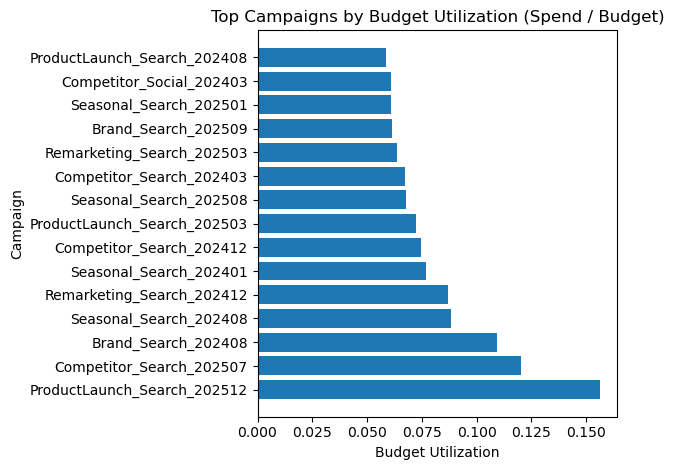

,campaign_name,spend,budget,budget_utilization_calc,roas


In [20]:
if has_cols(df, ["campaign_name","budget","spend"]):
    camp = df.groupby("campaign_name").agg(
        spend=("spend","sum"),
        budget=("budget","mean"),
        revenue=("revenue","sum") if "revenue" in df.columns else ("spend","sum"),
        net_revenue=("net_revenue","sum") if "net_revenue" in df.columns else ("spend","sum"),
        conversions=("conversions","sum") if "conversions" in df.columns else ("spend","sum"),
        clicks=("clicks","sum") if "clicks" in df.columns else ("spend","sum"),
        impressions=("impressions","sum") if "impressions" in df.columns else ("spend","sum"),
    ).reset_index()

    camp["budget_utilization_calc"] = camp["spend"] / camp["budget"].replace(0,np.nan)
    if has_cols(camp, ["revenue","spend"]):
        camp["roas"] = camp["revenue"] / camp["spend"].replace(0,np.nan)
    if has_cols(camp, ["net_revenue","spend"]):
        camp["net_roas"] = camp["net_revenue"] / camp["spend"].replace(0,np.nan)

    # Top campaigns by budget utilization
    top_pacing = camp.sort_values("budget_utilization_calc", ascending=False).head(15)

    plt.figure()
    plt.barh(top_pacing["campaign_name"], top_pacing["budget_utilization_calc"])
    plt.title("Top Campaigns by Budget Utilization (Spend / Budget)")
    plt.xlabel("Budget Utilization")
    plt.ylabel("Campaign")
    plt.tight_layout()
    plt.show()

    # "Waste radar": high utilization, low ROAS (if available)
    if "roas" in camp.columns:
        waste = camp[(camp["budget_utilization_calc"] >= 0.8) & (camp["roas"] <= camp["roas"].median())] \
                    .sort_values(["budget_utilization_calc","roas"], ascending=[False, True]) \
                    .head(15)
        display(waste[["campaign_name","spend","budget","budget_utilization_calc","roas"]])

else:
    print("Need campaign_name + budget + spend for budget pacing analysis.")

# 4) What’s driving performance: Channel, Platform, Creative, Placement?

- Which channel has the best Net ROAS?

- Which creative types have high CTR but low CVR (clickbait risk)?

- Which placements have expensive CPM but high conversion value?

,channel,impressions,clicks,spend,conversions,net_revenue,revenue,quality_score,ctr,cvr,cpc,cpm,cpa,net_roas
2,Email,138505,4325,1020.86,168,5906.68,6061.47,6.598182,0.031226,0.038844,0.236037,7.370564,6.076548,5.785984
0,Affiliate,154758,1540,1661.05,73,2233.60,2278.44,6.634783,0.009951,0.047403,1.078604,10.733209,22.754110,1.344692
3,Search,849651,39029,84739.75,2779,95705.27,98391.03,7.199642,0.045935,0.071203,2.171200,99.734773,30.492893,1.129402
1,Display,901733,3772,3196.38,52,1885.70,1942.96,6.778616,0.004183,0.013786,0.847397,3.544708,61.468846,0.589949
4,Social,1157589,15185,21340.47,327,11932.70,12232.81,6.704074,0.013118,0.021534,1.405365,18.435274,65.261376,0.559158
5,Video,523307,4662,5606.35,59,1986.06,2032.48,6.514159,0.008909,0.012656,1.202563,10.713310,95.022881,0.354252


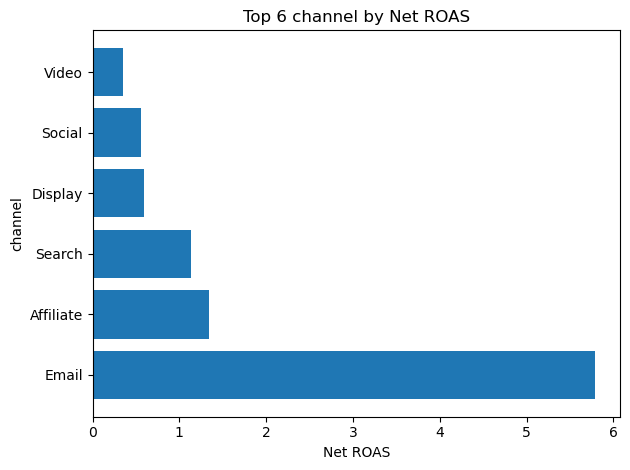

,platform,impressions,clicks,spend,conversions,net_revenue,revenue,quality_score,ctr,cvr,cpc,cpm,cpa,net_roas
3,ESP,138505,4325,1020.86,168,5906.68,6061.47,6.598182,0.031226,0.038844,0.236037,7.370564,6.076548,5.785984
0,Affiliate Network,154758,1540,1661.05,73,2233.60,2278.44,6.634783,0.009951,0.047403,1.078604,10.733209,22.754110,1.344692
1,Amazon Ads,312156,9604,18988.39,689,22242.97,22799.72,7.170423,0.030767,0.071741,1.977133,60.829809,27.559347,1.171398
4,Google Ads,1053512,32256,68694.02,2124,74737.91,76903.34,7.032343,0.030618,0.065848,2.129651,65.204782,32.341817,1.087983
2,DSP (Programmatic),567752,2579,2358.70,35,1283.85,1321.70,6.721359,0.004542,0.013571,0.914579,4.154455,67.391429,0.544304
6,Meta Ads,785754,9474,13295.02,193,7116.20,7306.37,6.715847,0.012057,0.020372,1.403316,16.920079,68.886114,0.535253
7,TikTok Ads,563992,6942,8610.42,133,4600.49,4693.44,6.617742,0.012309,0.019159,1.240337,15.266919,64.740000,0.534293
5,LinkedIn Ads,149114,1793,2936.40,43,1528.31,1574.71,6.781081,0.012024,0.023982,1.637702,19.692316,68.288372,0.520471


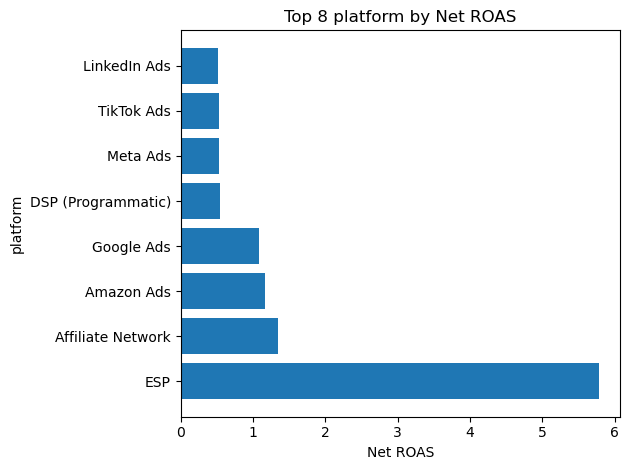

,creative_type,impressions,clicks,spend,conversions,net_revenue,revenue,quality_score,ctr,cvr,cpc,cpm,cpa,net_roas
2,Native,302418,5724,8638.53,295,10061.39,10375.90,6.717647,0.018927,0.051537,1.509177,28.564867,29.283153,1.164711
1,Long Video,351526,6532,11604.00,343,12999.27,13300.06,6.915534,0.018582,0.052511,1.776485,33.010361,33.830904,1.120240
4,Static,977181,17638,28059.30,867,29069.19,29842.28,6.782813,0.018050,0.049155,1.590844,28.714537,32.363668,1.035991
5,UGC,718907,14582,26062.67,750,26752.66,27603.48,6.756931,0.020284,0.051433,1.787318,36.253187,34.750227,1.026474
3,Short Video,779236,13452,24678.07,668,23472.67,24120.05,6.937113,0.017263,0.049658,1.834528,31.669571,36.943219,0.951155
0,Carousel,596275,10585,18522.29,535,17294.83,17697.42,6.786875,0.017752,0.050543,1.749862,31.063335,34.621103,0.933731


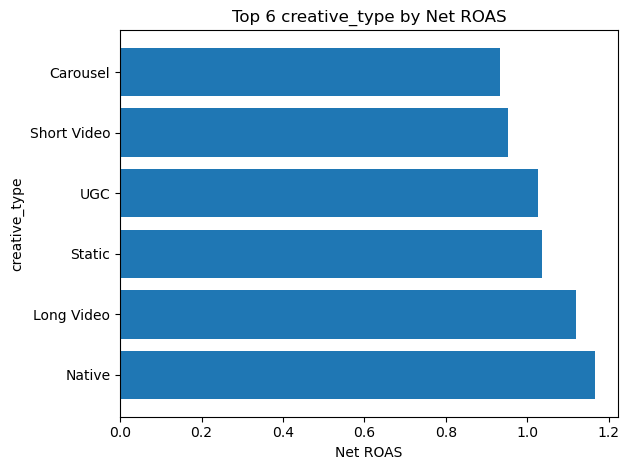

,placement,impressions,clicks,spend,conversions,net_revenue,revenue,quality_score,ctr,cvr,cpc,cpm,cpa,net_roas
3,Newsletter,193706,4771,1424.66,189,6470.59,6636.11,6.630827,0.024630,0.039614,0.298608,7.354754,7.537884,4.541849
6,Shopping Results,125252,5310,10544.61,370,12790.52,13126.33,6.954286,0.042395,0.069680,1.985802,84.187159,28.498946,1.212991
5,Search Results,724399,33719,74195.14,2409,82914.75,85264.70,7.234836,0.046548,0.071443,2.200396,102.423029,30.799145,1.117523
4,Publisher Site,596407,3187,3058.28,81,2831.86,2904.63,6.804878,0.005344,0.025416,0.959611,5.127841,37.756543,0.925965
1,Feed,791731,10651,14476.31,225,8303.07,8508.95,6.779558,0.013453,0.021125,1.359150,18.284379,64.339156,0.573563
0,App Inventory,404883,1679,1395.35,23,723.53,742.13,6.615854,0.004147,0.013699,0.831060,3.446304,60.667391,0.518529
7,Stories/Reels,506510,5813,8418.16,118,4179.96,4289.99,6.543220,0.011477,0.020299,1.448161,16.619929,71.340339,0.496541
8,YouTube,204753,1771,2242.40,27,963.70,985.88,6.677778,0.008649,0.015246,1.266177,10.951732,83.051852,0.429763
2,In-stream Video,177902,1612,1809.95,16,472.03,480.47,6.320513,0.009061,0.009926,1.122798,10.173860,113.121875,0.260797


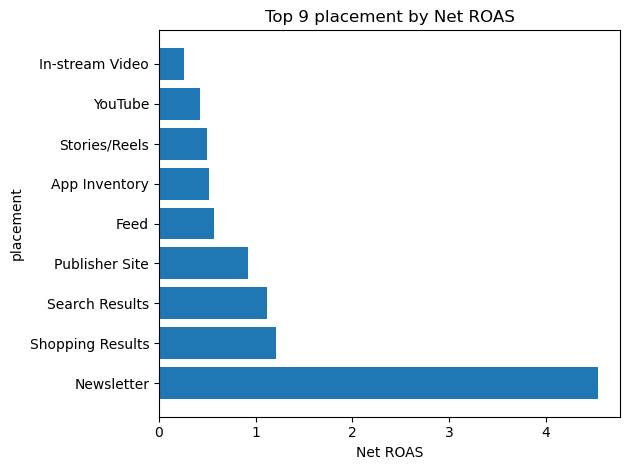

,audience_segment,impressions,clicks,spend,conversions,net_revenue,revenue,quality_score,ctr,cvr,cpc,cpm,cpa,net_roas
0,Cart Abandoners,331346,6376,12163.31,405,15043.86,15512.46,6.747778,0.019243,0.063519,1.907671,36.708788,30.032864,1.236823
1,High Intent,731116,14322,24356.15,839,27363.91,27998.68,6.924242,0.019589,0.058581,1.700611,33.313660,29.029976,1.123491
3,Loyal Customers,358244,6820,11892.14,428,12217.56,12465.41,6.777551,0.019037,0.062757,1.743716,33.195643,27.785374,1.027364
4,New Users,1074027,19307,30943.69,860,31010.63,31936.04,6.835739,0.017976,0.044543,1.602719,28.810905,35.981035,1.002163
2,Lookalike,524103,9334,17359.06,396,15792.67,16259.51,6.687591,0.017809,0.042426,1.859766,33.121467,43.836010,0.909765
5,Returning Users,706707,12354,20850.51,530,18221.38,18767.09,6.819355,0.017481,0.042901,1.687754,29.503755,39.340585,0.873906


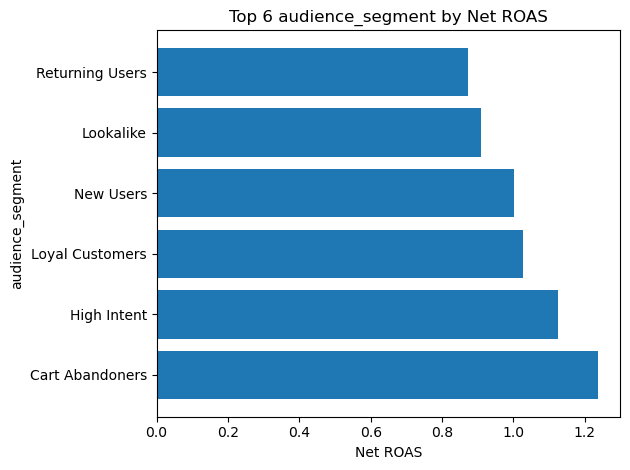

In [21]:
def performance_table(group_col, top_n=15):
    needed = [group_col, "spend", "impressions", "clicks", "conversions", "net_revenue"]
    if not all(c in df.columns for c in [group_col, "spend"]):
        print(f"Skipping {group_col}: missing required columns.")
        return None

    g = df.groupby(group_col).agg(
        impressions=("impressions","sum") if "impressions" in df.columns else ("spend","size"),
        clicks=("clicks","sum") if "clicks" in df.columns else ("spend","size"),
        spend=("spend","sum"),
        conversions=("conversions","sum") if "conversions" in df.columns else ("spend","size"),
        net_revenue=("net_revenue","sum") if "net_revenue" in df.columns else ("spend","sum"),
        revenue=("revenue","sum") if "revenue" in df.columns else ("spend","sum"),
        quality_score=("quality_score","mean") if "quality_score" in df.columns else ("spend","mean"),
    ).reset_index()

    if has_cols(g, ["clicks","impressions"]):
        g["ctr"] = g["clicks"] / g["impressions"].replace(0,np.nan)
    if has_cols(g, ["conversions","clicks"]):
        g["cvr"] = g["conversions"] / g["clicks"].replace(0,np.nan)
    if has_cols(g, ["spend","clicks"]):
        g["cpc"] = g["spend"] / g["clicks"].replace(0,np.nan)
    if has_cols(g, ["spend","impressions"]):
        g["cpm"] = g["spend"] * 1000 / g["impressions"].replace(0,np.nan)
    if has_cols(g, ["spend","conversions"]):
        g["cpa"] = g["spend"] / g["conversions"].replace(0,np.nan)
    if has_cols(g, ["net_revenue","spend"]):
        g["net_roas"] = g["net_revenue"] / g["spend"].replace(0,np.nan)

    return g.sort_values("net_roas" if "net_roas" in g.columns else "net_revenue", ascending=False).head(top_n)

for col in ["channel", "platform", "creative_type", "placement", "audience_segment"]:
    if col in df.columns:
        tbl = performance_table(col, top_n=12)
        if tbl is not None:
            display(tbl)

            # Visualize Net ROAS by group
            if "net_roas" in tbl.columns:
                plt.figure()
                plt.barh(tbl[col].astype(str), tbl["net_roas"])
                plt.title(f"Top {len(tbl)} {col} by Net ROAS")
                plt.xlabel("Net ROAS")
                plt.ylabel(col)
                plt.tight_layout()
                plt.show()

# 5) Funnel diagnostics: CTR vs CVR (Quality of traffic)



- Which campaigns/ad groups bring “cheap clicks” but don’t convert?

- Where does the funnel break?

,ad_group,spend,ctr,cvr,cpc,cpa,net_roas
27,AG_28,2846.2,0.023491,0.036707,1.582981,43.124242,0.773087


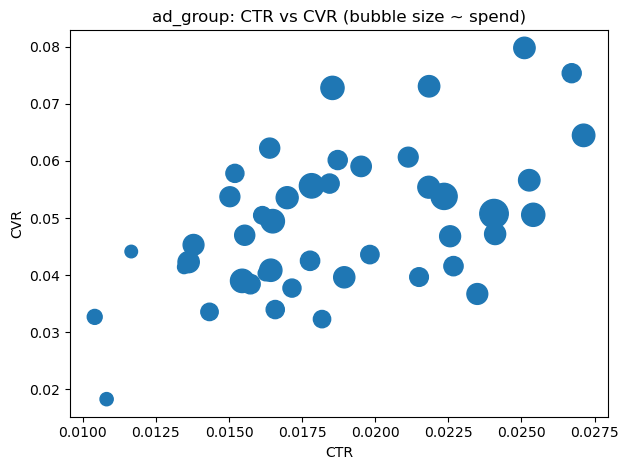

In [22]:
group_col = "ad_group" if "ad_group" in df.columns else ("campaign_name" if "campaign_name" in df.columns else None)

if group_col and has_cols(df, [group_col, "impressions", "clicks", "conversions", "spend"]):

    g = df.groupby(group_col).agg(
        impressions=("impressions","sum"),
        clicks=("clicks","sum"),
        conversions=("conversions","sum"),
        spend=("spend","sum"),
        net_revenue=("net_revenue","sum") if "net_revenue" in df.columns else ("spend","sum")
    ).reset_index()

    g["ctr"] = g["clicks"] / g["impressions"].replace(0,np.nan)
    g["cvr"] = g["conversions"] / g["clicks"].replace(0,np.nan)
    g["cpc"] = g["spend"] / g["clicks"].replace(0,np.nan)
    g["cpa"] = g["spend"] / g["conversions"].replace(0,np.nan)
    g["net_roas"] = g["net_revenue"] / g["spend"].replace(0,np.nan)

    # Identify "clickbait risk": high CTR but low CVR
    ctr_q = g["ctr"].quantile(0.75)
    cvr_q = g["cvr"].quantile(0.25)
    clickbait = g[(g["ctr"] >= ctr_q) & (g["cvr"] <= cvr_q)].sort_values("spend", ascending=False).head(15)

    display(clickbait[[group_col, "spend", "ctr", "cvr", "cpc", "cpa", "net_roas"]])

    # Scatter: CTR vs CVR sized by spend
    plt.figure()
    plt.scatter(g["ctr"], g["cvr"], s=(g["spend"].fillna(0) / max(g["spend"].max(),1) * 400 + 20))
    plt.title(f"{group_col}: CTR vs CVR (bubble size ~ spend)")
    plt.xlabel("CTR")
    plt.ylabel("CVR")
    plt.tight_layout()
    plt.show()

else:
    print("Need impressions/clicks/conversions/spend and campaign_name or ad_group for funnel diagnostics.")

# 6) Video performance: where do viewers drop?



- Do we have a creative problem (big drop-off)?

- Does watch time correlate with conversions?

,video_views,video_25pct,video_50pct,video_75pct,video_100pct,avg_watch_time_sec
0,119625.0,88435.0,65823.0,47065.0,32622.0,9.648673


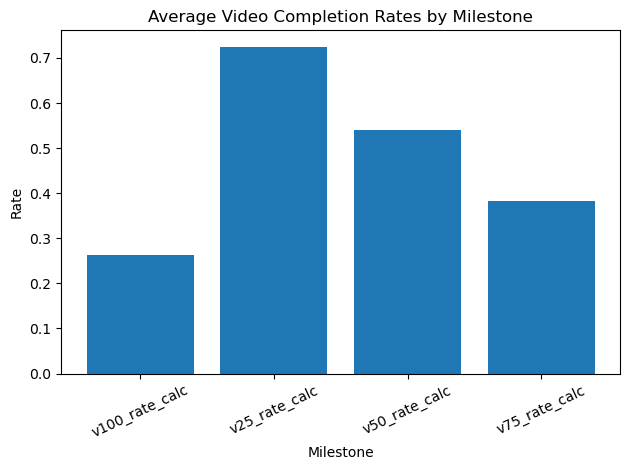

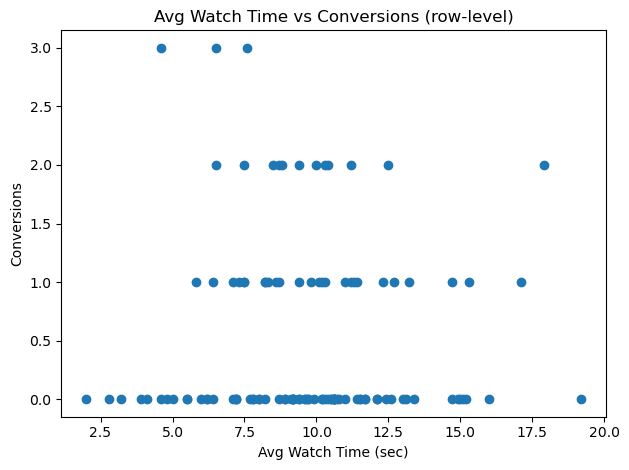

In [23]:
video_cols = ["video_views","video_25pct","video_50pct","video_75pct","video_100pct","avg_watch_time_sec"]
if any(c in df.columns for c in video_cols):

    # Aggregate overall
    v = {}
    for c in video_cols:
        if c in df.columns:
            v[c] = df[c].sum() if "pct" in c or "views" in c else df[c].mean()

    vdf = pd.DataFrame([v])
    display(vdf)

    # Rates if possible
    if has_cols(df, ["video_views","video_25pct"]):
        df["v25_rate_calc"] = df["video_25pct"] / df["video_views"].replace(0,np.nan)
    if has_cols(df, ["video_views","video_50pct"]):
        df["v50_rate_calc"] = df["video_50pct"] / df["video_views"].replace(0,np.nan)
    if has_cols(df, ["video_views","video_75pct"]):
        df["v75_rate_calc"] = df["video_75pct"] / df["video_views"].replace(0,np.nan)
    if has_cols(df, ["video_views","video_100pct"]):
        df["v100_rate_calc"] = df["video_100pct"] / df["video_views"].replace(0,np.nan)

    rate_cols = [c for c in ["v25_rate_calc","v50_rate_calc","v75_rate_calc","v100_rate_calc"] if c in df.columns]
    if rate_cols:
        rates = df[rate_cols].mean().sort_index()
        plt.figure()
        plt.bar(rates.index, rates.values)
        plt.title("Average Video Completion Rates by Milestone")
        plt.xlabel("Milestone")
        plt.ylabel("Rate")
        plt.xticks(rotation=25)
        plt.tight_layout()
        plt.show()

    # Watch time vs conversions (if available)
    if has_cols(df, ["avg_watch_time_sec","conversions"]):
        plt.figure()
        plt.scatter(df["avg_watch_time_sec"], df["conversions"])
        plt.title("Avg Watch Time vs Conversions (row-level)")
        plt.xlabel("Avg Watch Time (sec)")
        plt.ylabel("Conversions")
        plt.tight_layout()
        plt.show()

else:
    print("No video metrics found.")

# 7) Email marketing: are we fatiguing the audience?



- Are opens and clicks healthy?

- Do we see unsubscribes spike with higher frequency?

email_open_rate_calc        0.237429
email_ctr_calc              0.028500
email_click_to_open_calc    0.142258
dtype: float64

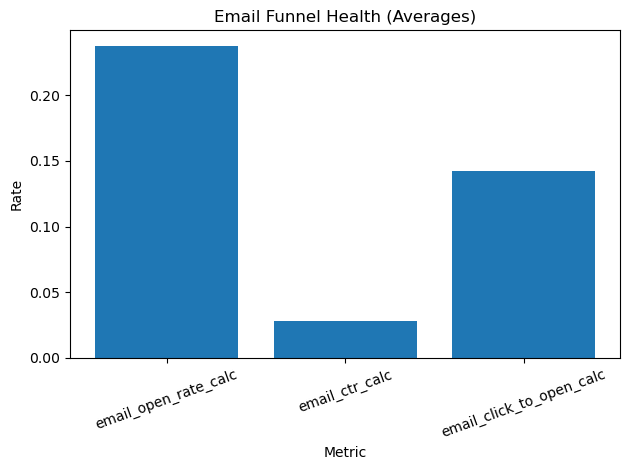

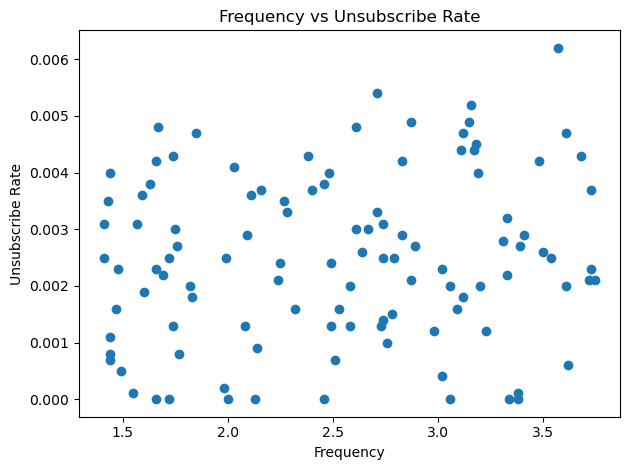

In [24]:
if has_cols(df, ["emails_sent","email_opens","email_clicks"]):
    df["email_open_rate_calc"] = df["email_opens"] / df["emails_sent"].replace(0,np.nan)
    df["email_ctr_calc"] = df["email_clicks"] / df["emails_sent"].replace(0,np.nan)
    df["email_click_to_open_calc"] = df["email_clicks"] / df["email_opens"].replace(0,np.nan)

    email_kpis = df[["email_open_rate_calc","email_ctr_calc","email_click_to_open_calc"]].mean()
    display(email_kpis)

    plt.figure()
    plt.bar(email_kpis.index, email_kpis.values)
    plt.title("Email Funnel Health (Averages)")
    plt.xlabel("Metric")
    plt.ylabel("Rate")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

    # Fatigue proxy: frequency vs unsubscribe (if present)
    if has_cols(df, ["frequency","unsubscribe_rate"]):
        plt.figure()
        plt.scatter(df["frequency"], df["unsubscribe_rate"])
        plt.title("Frequency vs Unsubscribe Rate")
        plt.xlabel("Frequency")
        plt.ylabel("Unsubscribe Rate")
        plt.tight_layout()
        plt.show()

else:
    print("No email columns found (emails_sent/email_opens/email_clicks).")

# 8) Audience + geo: where is profitable demand coming from?

- Which audience segments are most profitable?

- Which geo regions have high ROAS but low budget allocation?

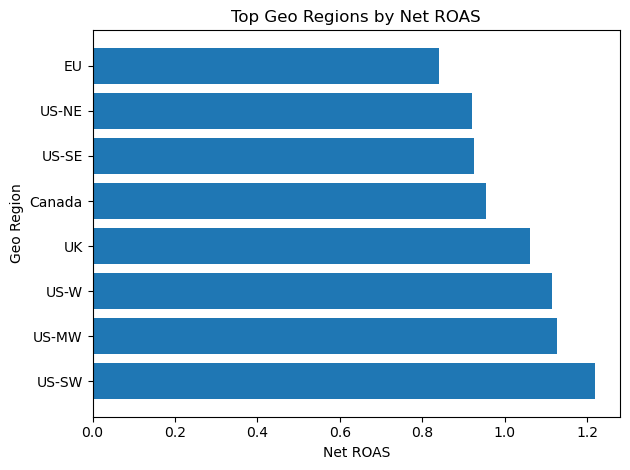

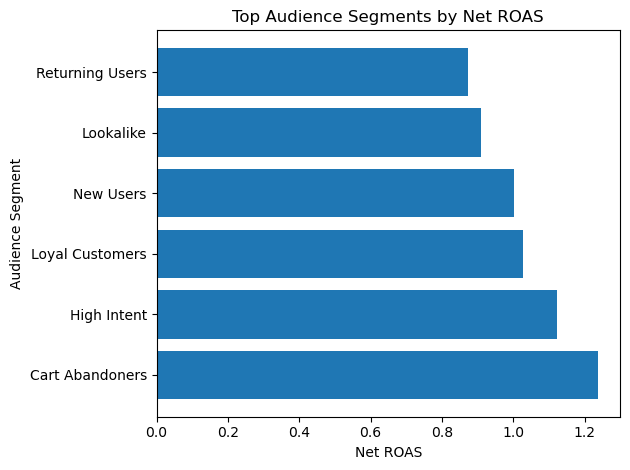

In [25]:
geo_col = "geo_region_US-NE"  # you have one-hot geos; we'll build a "geo_region" label if possible

# If you have a categorical geo field, use it:
if "geo_region" in df.columns:
    geo_field = "geo_region"
else:
    # Try reconstruct from one-hot columns like geo_region_US-NE, geo_region_UK, etc.
    geo_onehot = [c for c in df.columns if c.startswith("geo_region_")]
    if geo_onehot:
        df["geo_region"] = df[geo_onehot].idxmax(axis=1).str.replace("geo_region_","", regex=False)
        geo_field = "geo_region"
    else:
        geo_field = None

if geo_field and has_cols(df, ["spend","net_revenue"]):
    geo = df.groupby(geo_field).agg(
        spend=("spend","sum"),
        net_revenue=("net_revenue","sum"),
        conversions=("conversions","sum") if "conversions" in df.columns else ("spend","size"),
    ).reset_index()
    geo["net_roas"] = geo["net_revenue"] / geo["spend"].replace(0,np.nan)

    top_geo = geo.sort_values("net_roas", ascending=False).head(12)
    plt.figure()
    plt.barh(top_geo[geo_field].astype(str), top_geo["net_roas"])
    plt.title("Top Geo Regions by Net ROAS")
    plt.xlabel("Net ROAS")
    plt.ylabel("Geo Region")
    plt.tight_layout()
    plt.show()

if "audience_segment" in df.columns and has_cols(df, ["spend","net_revenue"]):
    aud = df.groupby("audience_segment").agg(
        spend=("spend","sum"),
        net_revenue=("net_revenue","sum"),
        clicks=("clicks","sum") if "clicks" in df.columns else ("spend","size"),
        conversions=("conversions","sum") if "conversions" in df.columns else ("spend","size"),
    ).reset_index()
    aud["net_roas"] = aud["net_revenue"] / aud["spend"].replace(0,np.nan)
    top_aud = aud.sort_values("net_roas", ascending=False).head(12)

    plt.figure()
    plt.barh(top_aud["audience_segment"].astype(str), top_aud["net_roas"])
    plt.title("Top Audience Segments by Net ROAS")
    plt.xlabel("Net ROAS")
    plt.ylabel("Audience Segment")
    plt.tight_layout()
    plt.show()

# 9) Attribution: how much is view-through contributing?

- What share of conversions are view-through?

- Which channels rely heavily on view-through (risk if window changes)?

Total conversions: 3,458
View-through conversions: 72
View-through share: 2.08%


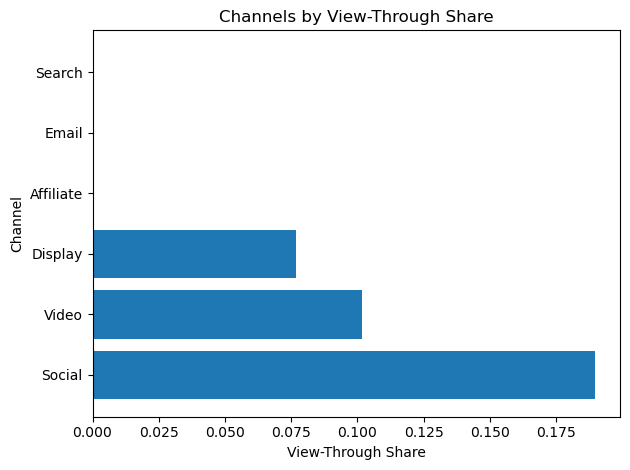

In [26]:
if has_cols(df, ["conversions","view_through_conversions"]):
    total_conv = df["conversions"].sum()
    vtc = df["view_through_conversions"].sum()
    share = vtc / max(total_conv, 1)

    print(f"Total conversions: {total_conv:,.0f}")
    print(f"View-through conversions: {vtc:,.0f}")
    print(f"View-through share: {share:.2%}")

    if "channel" in df.columns:
        ch = df.groupby("channel").agg(
            conversions=("conversions","sum"),
            view_through_conversions=("view_through_conversions","sum"),
            spend=("spend","sum") if "spend" in df.columns else ("conversions","sum"),
        ).reset_index()
        ch["vt_share"] = ch["view_through_conversions"] / ch["conversions"].replace(0,np.nan)
        top = ch.sort_values("vt_share", ascending=False).head(12)

        plt.figure()
        plt.barh(top["channel"].astype(str), top["vt_share"])
        plt.title("Channels by View-Through Share")
        plt.xlabel("View-Through Share")
        plt.ylabel("Channel")
        plt.tight_layout()
        plt.show()

else:
    print("No view-through columns found (view_through_conversions/conversions).")

# 10) Landing page effectiveness (conversion & revenue efficiency)

- Which landing pages produce high CVR and Net ROAS?

- Which pages get clicks but underperform on net revenue?

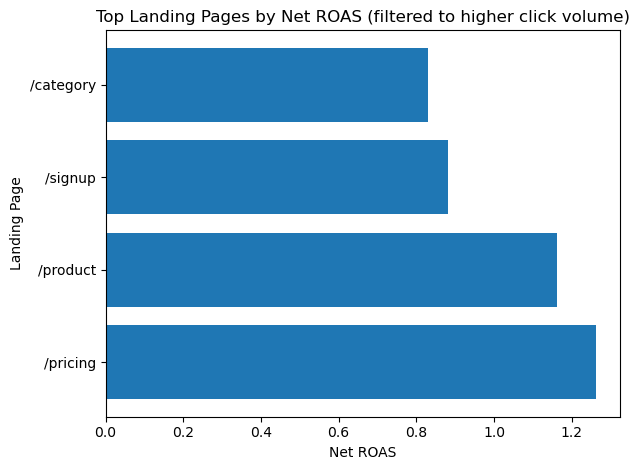

In [27]:
if "landing_page" in df.columns and has_cols(df, ["clicks","conversions","spend","net_revenue"]):
    lp = df.groupby("landing_page").agg(
        clicks=("clicks","sum"),
        conversions=("conversions","sum"),
        spend=("spend","sum"),
        net_revenue=("net_revenue","sum"),
        impressions=("impressions","sum") if "impressions" in df.columns else ("clicks","sum")
    ).reset_index()

    lp["cvr"] = lp["conversions"] / lp["clicks"].replace(0,np.nan)
    lp["net_roas"] = lp["net_revenue"] / lp["spend"].replace(0,np.nan)

    # Top landing pages by net_roas with some volume
    lp2 = lp[lp["clicks"] >= lp["clicks"].quantile(0.5)].sort_values("net_roas", ascending=False).head(12)

    plt.figure()
    plt.barh(lp2["landing_page"].astype(str), lp2["net_roas"])
    plt.title("Top Landing Pages by Net ROAS (filtered to higher click volume)")
    plt.xlabel("Net ROAS")
    plt.ylabel("Landing Page")
    plt.tight_layout()
    plt.show()

else:
    print("Need landing_page + clicks + conversions + spend + net_revenue for landing page analysis.")

# 1) Choose target

In [29]:
# ----------------------------
# 1) Choose target
# ----------------------------
df_knn = df_model.copy()

if "Clicked on Ad" in df_knn.columns:
    y = df_knn["Clicked on Ad"]
    # normalize target to 0/1 if it's not already
    if y.dtype == "object":
        y = y.astype(str).str.strip().str.lower().map({"1":1,"0":0,"yes":1,"no":0,"true":1,"false":0})
    y = pd.to_numeric(y, errors="coerce")
    print("Target: Clicked on Ad")
elif "conversions" in df_knn.columns:
    y = (pd.to_numeric(df_knn["conversions"], errors="coerce").fillna(0) > 0).astype(int)
    print("Target: conversions > 0 (derived)")
else:
    raise ValueError("No usable target found. Expected 'Clicked on Ad' or 'conversions'.")

# Drop rows where y is missing
mask = y.notna()
df_knn = df_knn.loc[mask].copy()
y = y.loc[mask].astype(int)

Target: Clicked on Ad


In [30]:
# ----------------------------
# 2) Build feature set
#    - Drop leaky or ID/text columns 
# ----------------------------
drop_cols = [
    "Clicked on Ad", "conversions",  # prevent leakage if using conversions-derived target
    "Ad Topic Line", "City", "Country", "Timestamp", "event_timestamp", "dt", "date", "dt_primary",
    "dt_day_floor", "landing_page", "keyword"  # optional: drop high-cardinality text fields
]
X = df_knn.drop(columns=[c for c in drop_cols if c in df_knn.columns], errors="ignore")

# Identify numeric/categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 240
Categorical features: 115


In [31]:
# ----------------------------
# 3) Preprocess
# ----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

In [32]:
# ----------------------------
# 4) Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
# ----------------------------
# 5) KNN + hyperparameter tuning
# ----------------------------
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", knn)
])

param_grid = {
    "model__n_neighbors": list(range(3, 32, 2)),         # odd ks
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]  # 1=Manhattan, 2=Euclidean
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("\nBest params:", grid.best_params_)
print("Best CV F1:", round(grid.best_score_, 4))


Best params: {'model__n_neighbors': 11, 'model__p': 2, 'model__weights': 'uniform'}
Best CV F1: 0.8141


In [34]:
# ----------------------------
# 6) Evaluate
# ----------------------------
y_pred = best_model.predict(X_test)

# KNN supports predict_proba
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print("\n--- Test Metrics ---")
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1       :", round(f1, 4))
print("ROC-AUC  :", round(auc, 4))


--- Test Metrics ---
Accuracy : 0.8
Precision: 0.8846
Recall   : 0.69
F1       : 0.7753
ROC-AUC  : 0.875


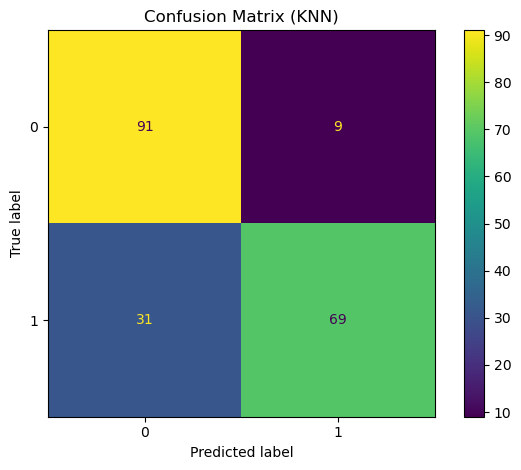

In [35]:

# 7) Confusion matrix
# ----------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (KNN)")
plt.tight_layout()
plt.show()

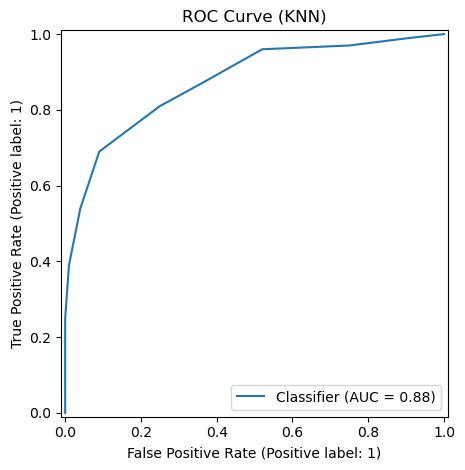

In [36]:
# ----------------------------
# 8) ROC curve
# ----------------------------
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve (KNN)")
plt.tight_layout()
plt.show()


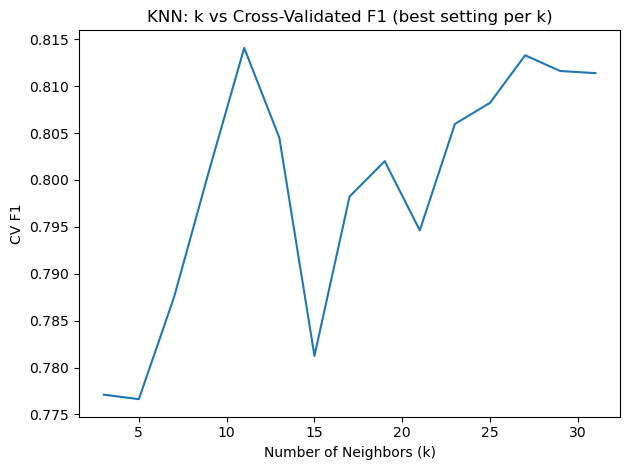

In [37]:
# ----------------------------
# 9) Plot k vs CV score (from grid results)
# ----------------------------
results = pd.DataFrame(grid.cv_results_)
# keep only one weight/p per k for easier plotting: choose best per k
results["k"] = results["param_model__n_neighbors"].astype(int)
best_per_k = results.sort_values("mean_test_score", ascending=False).groupby("k", as_index=False).head(1)
best_per_k = best_per_k.sort_values("k")

plt.figure()
plt.plot(best_per_k["k"], best_per_k["mean_test_score"])
plt.title("KNN: k vs Cross-Validated F1 (best setting per k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("CV F1")
plt.tight_layout()
plt.show()

Transformed feature count: 1591
Importance length: 355
                                    feature  importance
0             num__Daily Time Spent on Site    0.054172
97                         num__log1p_spend    0.053330
3                 num__Daily Internet Usage    0.037251
115             num__campaign_name__avg_ctr    0.036926
116             num__campaign_name__avg_cvr    0.036112
2                          num__Area Income    0.022378
114          num__sqrt_Daily Internet Usage    0.021648
113         num__log1p_Daily Internet Usage    0.021078
1                                  num__Age    0.019829
84                           num__v100_rate    0.018867
151             num__ad_group__avg_net_roas    0.017437
41            num__view_through_conversions    0.015694
63             num__emails_sent__is_missing    0.014305
60             num__video_75pct__is_missing    0.014305
64             num__email_opens__is_missing    0.014305
61            num__video_100pct__is_missing    0.

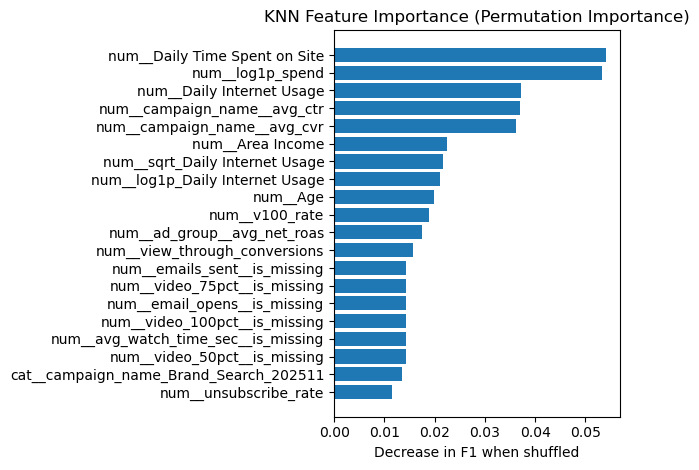

In [45]:
result = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="f1"
)

# 2) Get feature names from the fitted preprocessor (robust)
preprocess = best_model.named_steps["preprocess"]

try:
    feature_names = preprocess.get_feature_names_out()
except Exception as e:
    # Fallback: transform a small sample to infer the number of output columns
    Xt = preprocess.transform(X_test.iloc[:5])
    n_out = Xt.shape[1]
    feature_names = np.array([f"feature_{i}" for i in range(n_out)])
    print("Warning: could not extract feature names; using generic names.", e)

# 3) Safety check to prevent length mismatch
n_imp = len(result.importances_mean)
n_feat = len(feature_names)
print("Transformed feature count:", n_feat)
print("Importance length:", n_imp)

# Align lengths if needed (last-resort guardrail)
m = min(n_feat, n_imp)
feature_names = feature_names[:m]
importances = result.importances_mean[:m]

# 4) Create importance df
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# 5) Show + plot top 20
top = importance_df.head(20)

print(top)

plt.figure()
plt.barh(top["feature"].astype(str), top["importance"])
plt.title("KNN Feature Importance (Permutation Importance)")
plt.xlabel("Decrease in F1 when shuffled")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
